In [1]:
library(purrr)
library(tidyverse)
library(Seurat)
library(ggplot2)
library(scales)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v dplyr   1.0.2
v tibble  3.0.4     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.0
v readr   1.4.0     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat':
  method     from
  print.boxx cli 


Attaching package: 'scales'


The following object is masked from 'package:readr':

    col_factor


The following object is masked from 'package:purrr':

    discard




In [2]:
source('paths.R')
source('plotting.R')
source('misc.R')
source('factors.R')

In [3]:
p_from_odds <- function(o) o/(1+o)
odds_from_p <- function(p) p/(1-p)

# 1. Load Data

In [4]:
m <- load_object(path_at('out', 'cache')('annotated', 'metadata', 'Robj')) %>% filter(!is.na(cell_type))

# 2. Plot frequencies of viral load classes

In [5]:
vlc_counts <- m %>% group_by(condition, cell_type, viral_load_class) %>% count(name='n_class')
group_counts <- m %>% group_by(condition, cell_type) %>% count(name='n_group')
vlc_freqs <- vlc_counts %>% left_join(group_counts) %>% mutate(vlc_freq=n_class/n_group)

Joining, by = c("condition", "cell_type")



In [6]:
label_pct <- function(x) sprintf('%.0f%%', x)
label_empty <- function(x) ''

label_pct_omit_small <- function(x, threshold=5) {
    if_else(x > threshold, label_pct(x), NULL)
}

Warning message:
"Removed 28 rows containing missing values (geom_text)."


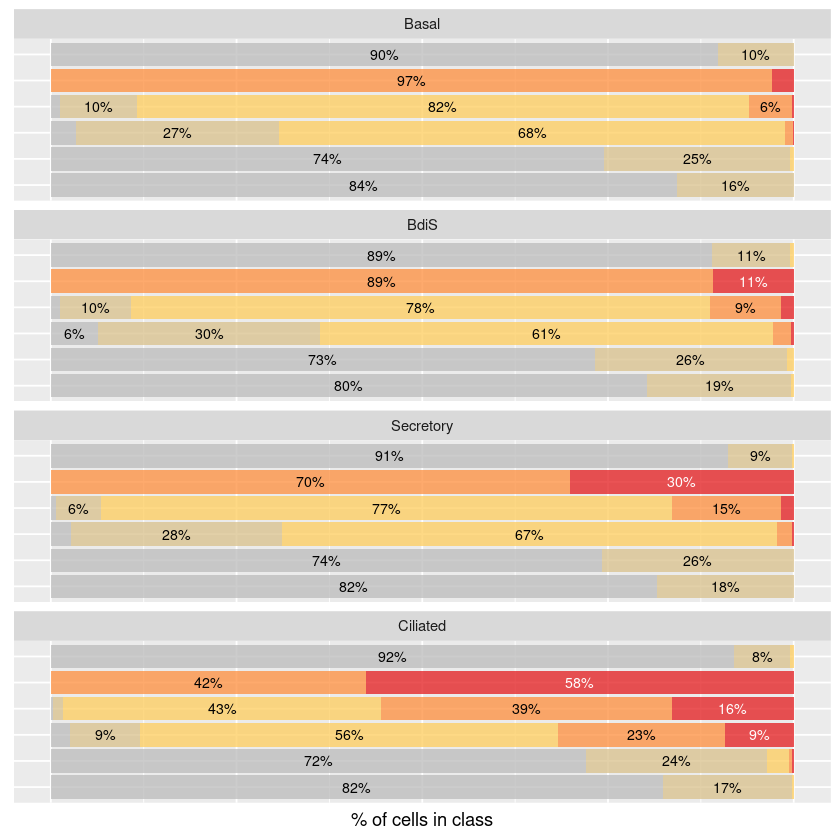

In [7]:
freqs_plot <- (
    vlc_freqs
    %>% arrange(condition)
    %>% data.frame()
    %>% ggplot(aes(x=condition, y=vlc_freq, fill=viral_load_class))
    + geom_col(position=position_stack(reverse=TRUE), alpha=0.75)
    + geom_text(
        aes(label = label_pct_omit_small(vlc_freq*100), color=viral_load_class),
        position = position_stack(vjust=0.5, reverse=TRUE),
        size = 3)
    + facet_wrap(vars(cell_type), ncol=1)
    + scale_x_discrete(limits=rev(levels(m$condition)))
    + scale_fill_manual(values=vlc_meta$color_fill)
    + scale_color_manual(values=vlc_meta$color_text)
    + coord_flip()
    + ylab('% of cells in class')
    + theme(axis.ticks=element_blank(), axis.text=element_blank(), axis.title.y=element_blank(), legend.position='none')
    + guides(legend=NULL)
)

freqs_plot

# 3. Violin plot on logg odds scale

In [8]:
vlc_thresholds <- c(1.2075398790045e-05, 0.000118284337541104, 0.000666533359994668, 0.0357430935802426)

In [9]:
class_annotations <- (
    vlc_meta
    %>% mutate(
        label = substr(viral_load_class, 1, 1),
        log_odds_viral = c(-12, -10, -8.5, -5.5, 0),
        condition = c('Mock steady state', 'Infected untreated', 'Mock steady state', 'Mock steady state', 'Mock steady state'),
        cell_type = factor(rep('Basal', 5), levels=levels(m$cell_type), ordered=TRUE)
    )
)

In [10]:
options(repr.plot.width=10, repr.plot.height=8)

axis_pct_viral <- sec_axis(
  trans = ~p_from_odds(exp(.x))*100,
  name = '% of viral transcripts (per cell)',
  breaks = c( 0.0012,   0.012,   0.066,   0.66,   3.57,    26,    73),
  labels = c('0.001%', '0.01%', '0.07%', '0.7%', '3.6%', '26%', '73%'),
  guide = waiver()
)

pv <- (
    m
    %>% filter(frac_viral > 0)
    %>% mutate(log_odds_viral = frac_viral %>% odds_from_p %>% log)
    %>% ggplot(aes(x=condition, color=condition, y=log_odds_viral))
    + coord_flip()
    + geom_hline(
        data = data.frame(frac_viral=vlc_thresholds) %>% mutate(log_odds_viral = odds_from_p(frac_viral) %>% log),
        mapping = aes(yintercept=log_odds_viral),
        color = 'darkorange4',
        linetype = 'dotted')
    + geom_label(
        data = class_annotations,
        mapping = aes(label=label),
        size = 3,
        color = class_annotations$color_text,
        fill = class_annotations$color_fill,
        label.size = 0)
    + geom_jitter(size=0.15)
    + geom_violin(adjust=.75, scale='width', width=0.9, alpha=0.675, draw_quantiles = 0.5)
    + ylab('log odds of viral transcripts frequencies (per cell)')
    + facet_wrap(vars(cell_type), ncol=1)
    + scale_color_manual(values=condition_colors)
    + scale_fill_manual(values=condition_colors)
    + scale_x_discrete(limits=rev(condition_levels))
    + theme(axis.ticks.y=element_blank(), axis.title.y=element_blank(), legend.position='none')
    + guides(color=guide_legend(override.aes = list(size=2)))
    + scale_y_continuous(
        breaks=c(-12, -10, -8, -6, -4, -2, 0, 2),
        minor_breaks=seq(-11, 1, 2),
        sec.axis=axis_pct_viral
    )
)

# 4. Figure 3 A B

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message:
"Removed 28 rows containing missing values (geom_text)."
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning messag

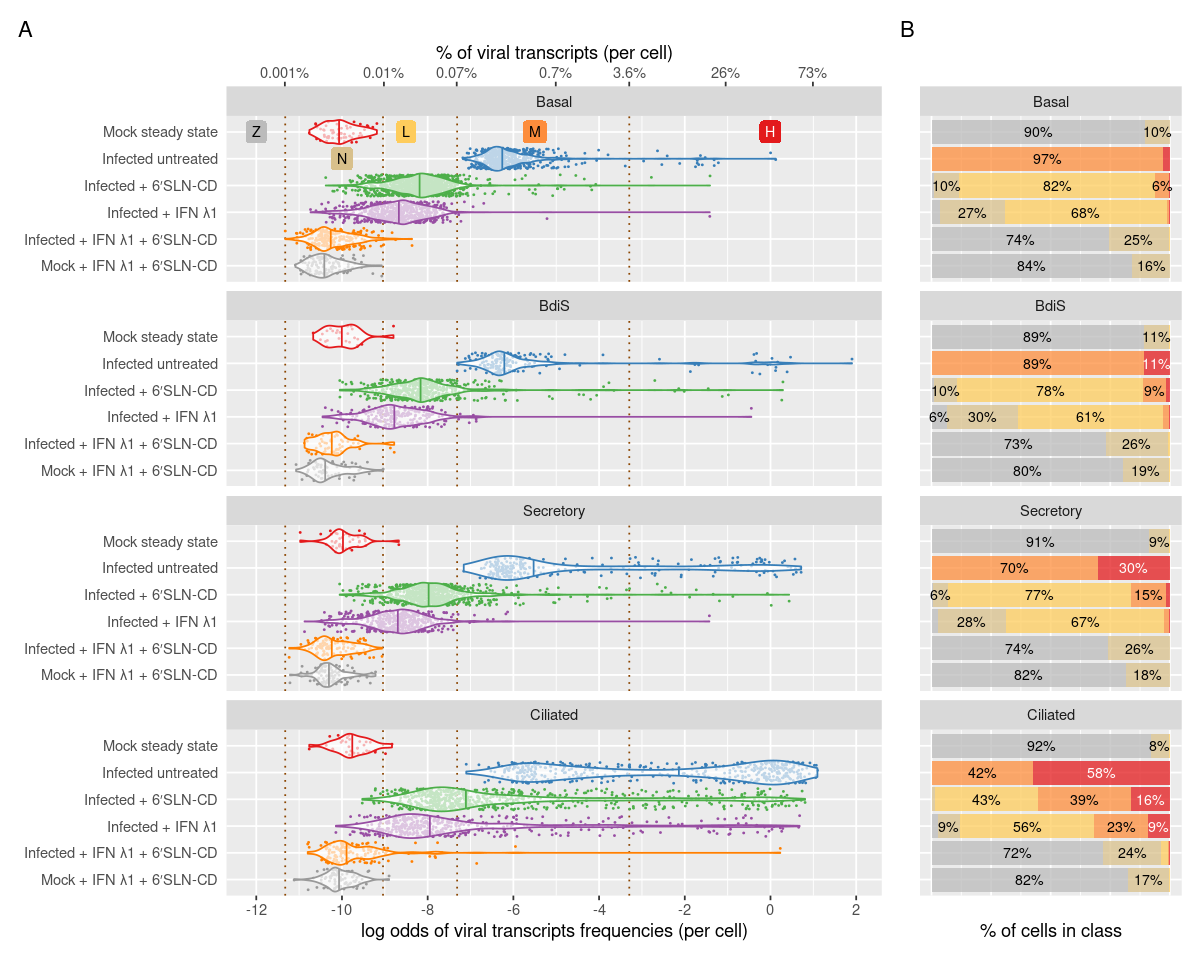

In [11]:
c <- pv + freqs_plot + patchwork::plot_layout(widths=c(2.5,1)) + patchwork::plot_annotation(tag_levels='A')
ggsave(path_at('out', 'figures')('Figure_3AB.png'), width=10, height=8, dpi=250)#print(c)
c

Figure XXX. Within-cell viral load across cell types and conditions (log odds scale).

A) Violin plots of within-cell proportions of viral transcripts on log odds scale (by cell type and condition) and viral load classes: zero (Z), noise (N), low (L), medium (M) and high (H) (see Methods). B) Fractions of cells in viral load clases within cell type and condition groups. The thresholds defining the viral load classes as per Table 2 are shown as vertical lines in Panel A.

# 6. Figure 3C

In [12]:
d <- load_object(path_at('out', 'cache')('annotated', 'Robj'))
x <- d@meta.data$condition_text %>% fct_recode(
    `SS`='Mock steady state',
    `IAV`='Infected untreated',
    `IAV+CD`='Infected cyclodextrin',
    `IAV+IF`='Infected interferon lambda',
    `IAV+IF+CD`='Infected combined treatment',
    `IF+CD`='Mock combined treatment'
)
d <- AddMetaData(d, x, 'condition_short2')

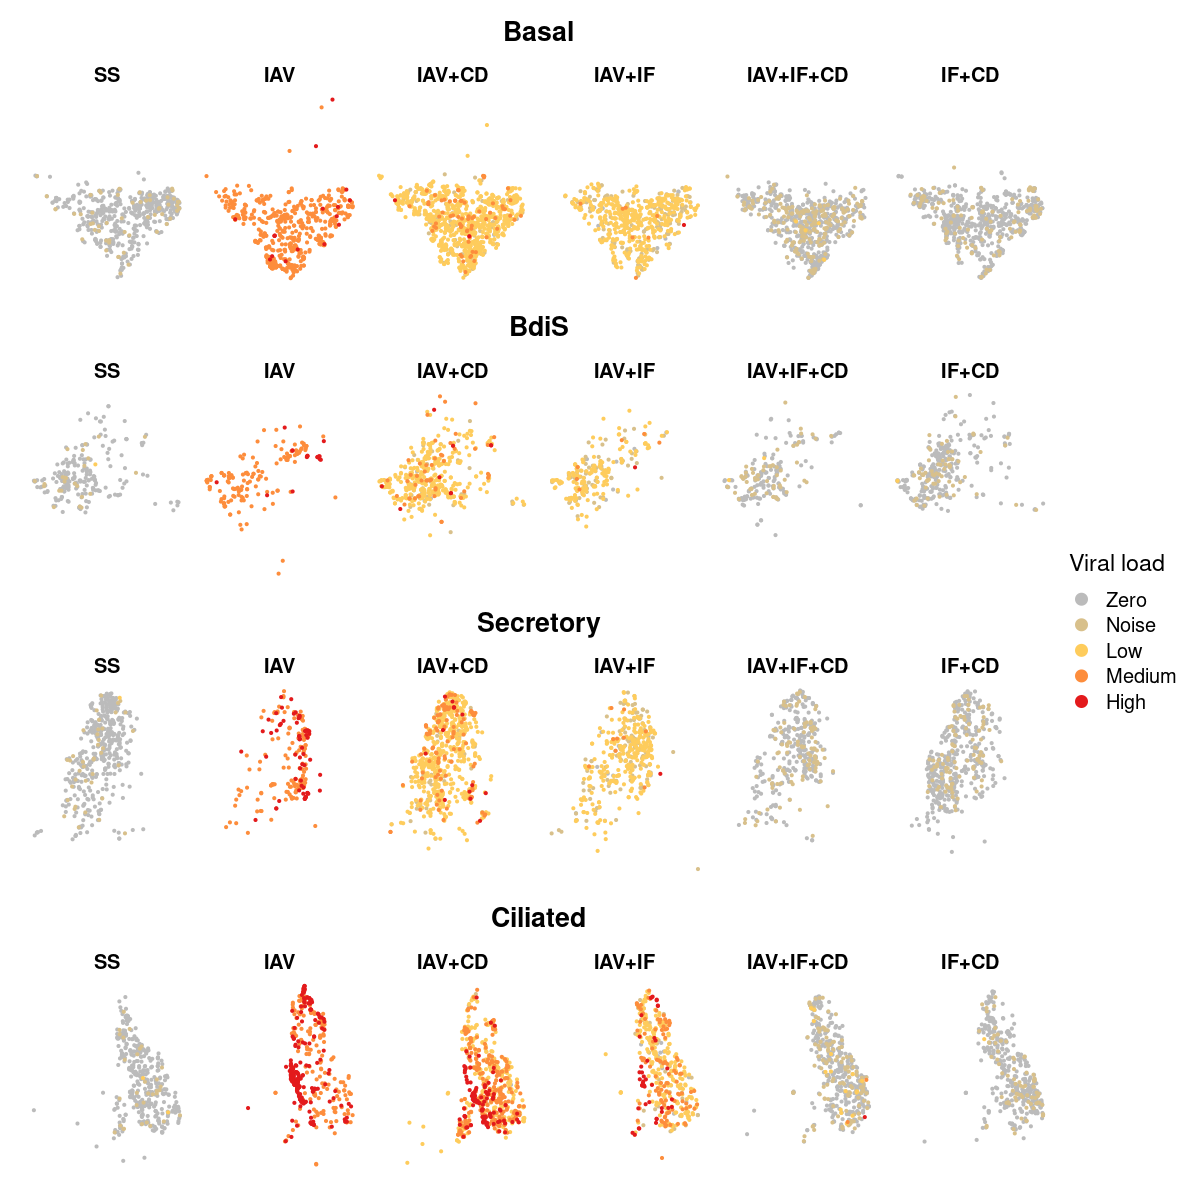

In [13]:
options(repr.plot.width=10, repr.plot.height=10)

dimplot <- function(d, cell_type) (
    DimPlot(
        d[,d@meta.data$cell_type == cell_type],
        reduction = 'tsne_pcs',
        group.by='viral_load_class',
        split.by = c('condition_short2'),
        pt.size = 0.5,
        order = rev(vlc_meta$viral_load_class)
    )
    + scale_color_manual(values=vlc_meta$color_fill, name='Viral load')
    + ggtitle(cell_type)
    + theme(
        axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        #legend.position = 'none'
    )
)

(
    dimplot(d, 'Basal')
    + dimplot(d, 'BdiS')
    + dimplot(d, 'Secretory')
    + dimplot(d, 'Ciliated')
    + patchwork::plot_layout(ncol=1, guides='collect')
)

ggsave(path_at('out', 'figures')('Figure_3C.png'), width=10, height=10, dpi=250)

# 6. SessionInfo

In [14]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux bullseye/sid

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
[1] C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.1.1    Seurat_3.2.3    forcats_0.5.0   stringr_1.4.0  
 [5] dplyr_1.0.2     readr_1.4.0     tidyr_1.1.2     tibble_3.0.4   
 [9] ggplot2_3.3.3   tidyverse_1.3.0 purrr_0.3.4    

loaded via a namespace (and not attached):
  [1] Rtsne_0.15            colorspace_2.0-0      deldir_0.2-3         
  [4] ellipsis_0.3.1        ggridges_0.5.3        IRdisplay_0.7.0      
  [7] base64enc_0.1-3       fs_1.5.0              spatstat.data_1.7-0  
 [10] rstudioapi_0.13       farver_2.0.3          leiden_0.3.6         
 [13] listenv_0.8.0         ggrepel_0.9.0         fansi_0.4.1          
 [16] lubr